In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras import models

2022-12-17 20:49:21.693198: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-17 20:49:21.835199: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-17 20:49:21.835234: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-17 20:49:22.536586: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [2]:
train_ds, test_ds , val_ds= tfds.load('eurosat/rgb', split=['train[:60%]', 'train[60%:80%]', 'train[80%:]'], shuffle_files=False, as_supervised=True)

2022-12-17 20:49:26.421457: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-17 20:49:26.421490: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-17 20:49:26.421509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-488978): /proc/driver/nvidia/version does not exist
2022-12-17 20:49:26.421778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
labels = []
for _, label in train_ds:
    labels.append(label.numpy())
labels = np.unique(labels)

In [4]:
BATCH_SIZE = 32
img_height=64
img_width =64
IMG_SIZE = (img_height, img_width)
def resize_image(images, labels):
    images = tf.image.resize(images, IMG_SIZE)
    return images, labels

In [5]:
train_ds = train_ds.map(resize_image).batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.map(resize_image).batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.map(resize_image).batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
tf.keras.utils.set_random_seed(42)

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10)
])

In [7]:
# Compile the model
model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [8]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
507/507 [==============================] - 18s 33ms/step - loss: 1.3203 - accuracy: 0.4869 - val_loss: 1.0846 - val_accuracy: 0.6013
Epoch 2/15
507/507 [==============================] - 16s 31ms/step - loss: 0.8391 - accuracy: 0.6954 - val_loss: 0.7176 - val_accuracy: 0.7331
Epoch 3/15
507/507 [==============================] - 16s 31ms/step - loss: 0.6551 - accuracy: 0.7619 - val_loss: 0.6613 - val_accuracy: 0.7506
Epoch 4/15
507/507 [==============================] - 16s 32ms/step - loss: 0.5755 - accuracy: 0.7944 - val_loss: 0.5578 - val_accuracy: 0.7944
Epoch 5/15
507/507 [==============================] - 16s 32ms/step - loss: 0.5113 - accuracy: 0.8182 - val_loss: 0.5613 - val_accuracy: 0.7963
Epoch 6/15
507/507 [==============================] - 18s 35ms/step - loss: 0.4426 - accuracy: 0.8442 - val_loss: 0.5895 - val_accuracy: 0.7893
Epoch 7/15
507/507 [==============================] - 17s 33ms/step - loss: 0.3998 - accuracy: 0.8580 - val_loss: 0.5627 - val_accuracy:

In [9]:
test_loss, test_acc = model.evaluate(test_ds)
print('Test accuracy: ', test_acc)

169/169 [==============================] - 2s 14ms/step - loss: 0.6408 - accuracy: 0.8324
Test accuracy:  0.8324074149131775


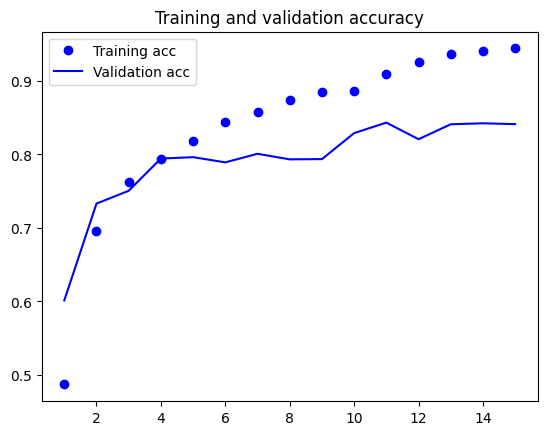

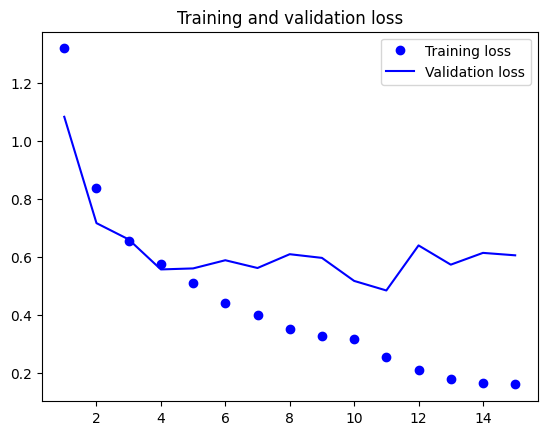

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

169/169 [==============================] - 2s 13ms/step


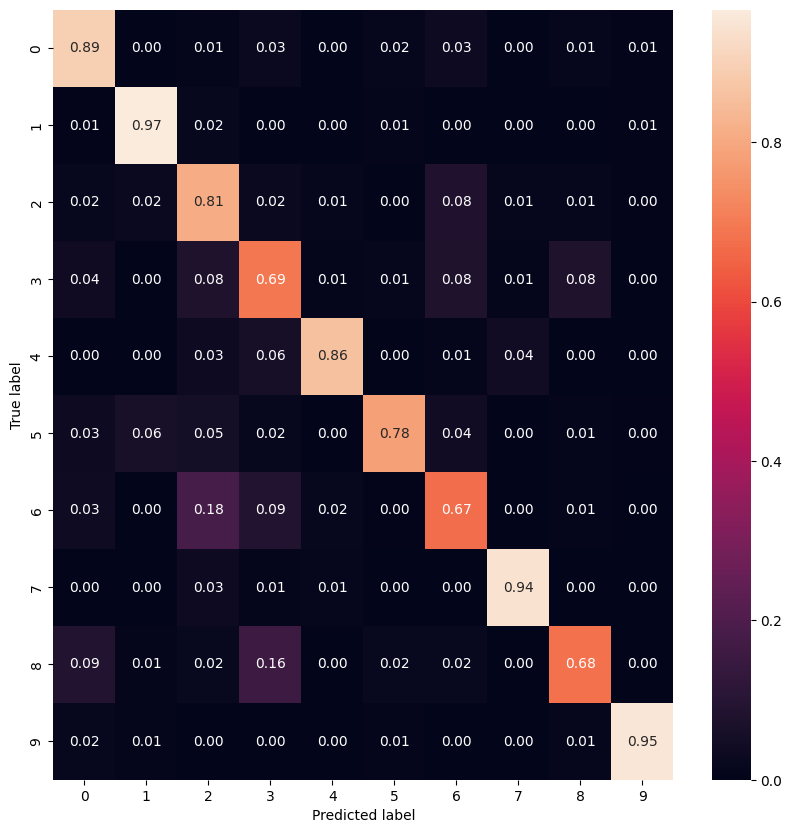

In [11]:
# Show the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = []
for _, label in test_ds:
    y_true.append(label.numpy())
y_true = np.concatenate(y_true)

cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       598
           1       0.92      0.97      0.94       593
           2       0.70      0.81      0.75       611
           3       0.61      0.69      0.65       461
           4       0.94      0.86      0.89       504
           5       0.90      0.78      0.84       446
           6       0.72      0.67      0.69       524
           7       0.94      0.94      0.94       599
           8       0.83      0.68      0.75       493
           9       0.98      0.95      0.96       571

    accuracy                           0.83      5400
   macro avg       0.84      0.82      0.83      5400
weighted avg       0.84      0.83      0.83      5400

